# Tools used 

-Python 3

-NLTK for processing and cleaning 

-regex for cleaning data

-Seaborn and matplotlib for visulization

-Scikit learn for machine learning models

In [1]:
import pandas as pd
from nltk.stem.isri import ISRIStemmer
import nltk
import gensim
import gensim.models.word2vec as w2v
import seaborn as sns
import matplotlib.pyplot as plt 
import regex
import re
import numpy as np
import unicodedata
%matplotlib inline

In [2]:
data = pd.read_csv('Arabic/NU_EG_Twitter_corpus_train.csv')
data['sent'] = data['class']
data = data.drop('class', 1)
stopWords = "Arabic/arabicStops.txt"

In [3]:
filepath = "Arabic/SemEval2017-train_arabic.txt"
df = pd.DataFrame()
with open(filepath, 'r', encoding='utf-8') as f:
    for line in f:
        df = pd.concat( [df, pd.DataFrame([tuple(line.strip().split('\t'))])], ignore_index=True )
        

In [4]:
test = pd.read_csv('Arabic/arabic_test.csv')
test.head(5)

,id,tweet
0,3,كل حلم بألم .. كل خطوه بعذاب ..
1,7,العسكري مدرس التاريخ في شبرا جايب عربيات همر ل...
2,8,الشقااااااااااوة لعبتى والشمال مش سكتى ؟
3,9,@memoali4ever انا كان عندي حساب واتقفل كان عن...
4,18,"""""""@mahmoud_turkey0 ياعم أتنيل، دي كفاية أمها ..."


Now I created a dataframe, merging the two data files just for ease ot use 

In [5]:
df.columns = ['id', 'sent', 'tweet']

In [6]:
my_data = pd.concat([data, df], ignore_index=True)
my_data['sent'] = my_data['sent'].replace(['pos'], 'positive')
my_data['sent'] = my_data['sent'].replace(['neg'], 'negative')
my_data['sent'] = my_data['sent'].replace(['neu'], 'neutral')

In [393]:
my_data = my_data.drop_duplicates()
my_data.shape

(6064, 3)

In [8]:
my_data.sent.value_counts()

neutral     2189
negative    2092
positive    1783
Name: sent, dtype: int64

# Reading stopwords

In [10]:
with open(stopWords, 'r', encoding='utf-8') as f:
    stopwords1 = f.readlines()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Base line experiment 

we started with 56.1 % accuracy with a bold model before any preprocessing or features or parameters tuning

using Bernoulli Naive Bayes and a test set of 20%

In [12]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
#nb = GaussianNB()
nb = BernoulliNB(alpha=1.3)

In [487]:
nb1 = MultinomialNB(alpha=2.5)

In [183]:
Analyzer = TfidfVectorizer().build_analyzer()

In [458]:
tf = TfidfVectorizer(min_df=2, max_df=0.9, stop_words=stopwords1, ngram_range=(1,2), analyzer=Analyzer, max_features=2500, lowercase=False)

After tuning all parameters and switching to Multinomial Naive Bayes our accuracy went up to 60.8 % accuracy

# Cleaning Data

We handled all the cleaning and the features generation in the cleaning function

we removed all emoticons and replaced them with the emotion they represent wheather happy or sad or meh

We replaced all links in the documents and with the word لينك 

We also replaced all mentions with the word منشن

after that we removed all non arabic words with all digits, punctuations, extra spaces and strange characters and stop words

we tried ISRI stemmer at the beginning and then we used the stemmer provided by Dr Samhaa

In [459]:
def clean(text):
        
        def remove_elongation(text):        

            return regex.sub(r'(.)\1{3,}',r'\1\1', text, flags=regex.UNICODE)

        #remove tashkeel 
        tashkeel = r"[ًٌٍَُِّ~ْ:؛×ًٌٍَِّْ]"
        text = regex.sub(tashkeel,"", text, flags=regex.UNICODE)
      
        
        r = u"بتثجحخدذرزسشصضطظعغفقكلمنهةويى1234567890ؤئءأالا=abcdefghijklmnopqrstuvwxyz\\/-+!.:><*%&:?)($,\"'@"
        #smileys = u"😍❤😘😖😀😁😂😃😄😅😆😇😈😉😊😋😌😍😎😏😐😑😒😓😔😕😖😗😘😙😚😛😜😝😞😟😠😡😢😣😥😦😧😨😩😪😫😭😮😯😰😱😲😳😴😵😶😷😸😹😺😻😼😽😾😿🙀"
        smileys = u"😍😘😀😁😂😃😄😅😆😇😈😉😊😋😌😍😎😗😘😙😚😛😜😝😸😹😺😻😽❤"
        sad = u"😓😔😕😖😞😟😠😡😢😣😥😦😧😨😩😪😫😭😮😯😰😱😲😵😶😷😾😿🙀"
        neu = u"😳😴😼😒😗😐😑😏"
        r = r+smileys+sad+neu
        
        
        for l in [t for t in text if t not in r]: 
            text = text.replace(l," ")
            
        for x in [t for t in text if t  in smileys]:
            text = text.replace(x, " سعيد ")
            
        for x in [t for t in text if t in sad]:
            text = text.replace(x, " حزين ")
            
        for x in [t for t in text if t in neu]:
            text = text.replace(x, "عادى")
            
        #for x in[t for t in ]
        
        text = re.sub(r'http[s]*', r'لينك', text)
        text = re.sub(r'@[a-zA-Z]*', r'منشن', text)
        #text = re.sub(r'#[ةجحخهعغفقثصضشسيبلاتنمكورزدذطظ]*', r'هاشتاج', text)
        
        punc = ".?!,/\|:،"
        
        #separating punc from original words
        
        for p in punc:
            text = text.replace(p," ")
            #text = text.replace(p," "+p+" ")
            
        #for word in text.split(" "):
        #    if word in stopwords1:
        #        text = text.replace(word, " ")
        
        text = unicodedata.normalize('NFC', text).encode('utf-8', 'ignore').decode()


        text  = " ".join([word for word in text.split(' ') if word not in stopwords1])


        text = "".join([i for i in text if not i.isdigit()])
        
        text = "".join([w for w in text if not re.match(r'[a-zA-Z]+', w, re.I)])

        #removing extra spaces
        text = regex.sub(r'[\s\n]+',' ', text, flags=regex.UNICODE)
        
        
        

       
        return text

In [239]:
tweets = tf.fit_transform(sentences)

# Normalizing the data

We tried multiple ways but the min max scaler worked the best for us

In [240]:
norm = Normalizer()
sc = StandardScaler()
mn = MinMaxScaler(feature_range=(0,1))
tweets1 = mn.fit_transform(tweets.toarray())

In [206]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(my_data.sent)
y.shape

(6064,)

# This is the training file after performing the stemmer provided by Dr Samhaa

In [436]:
filename = 'train1_out.txt'

In [439]:
def parse_my_file(filename):
    with open(filename, encoding='utf-8') as f:
        for line in f:
            yield line.strip().split(' ', 1)

In [541]:
df = pd.DataFrame(parse_my_file(filename))
df.columns = ['sent', 'tweet']

In [542]:
df = df.drop(df.index[0])

In [543]:
df.shape

(6064, 2)

# Now we convert the data into tfidf vectors and then we normalize these vectors

In [544]:
tweets = tf.fit_transform(sentences)
tweets1 = norm.fit_transform(tweets.toarray())

Training the data

In [549]:
X_train, X_test, y_train, y_test = train_test_split(tweets1, my_data.sent, test_size = 0.2, random_state = 0)

In [550]:
nb1.fit(tweets1, df.sent)
pred = nb1.predict(test)
#acc = accuracy_score(y_test, pred)
#conf = confusion_matrix(y_test, pred)
#acc

We were able to reach 62% using the training data after tuning all these features and parameters 

we tried SVM, Logistic Regression and Bernoulli Naive bayes 
Multinomial naive bayes gave the best result

# reading the data provided by Kaggle

In [588]:
test = open('test_out.txt', encoding='utf-8')

In [589]:
test = tf.transform(test)

In [590]:
predictions = nb1.predict(test)

# we used Multiple ways to look into the data try to generate more features 

# we used tsne to squash the data into two dimensions to try to look at the data

In [591]:
tsne = TSNE(n_components=2, random_state=0)

In [592]:
word_matrix = tsne.fit_transform(tweets1)

In [593]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_matrix[tf.vocabulary_[word]])
            for word in tf.vocabulary_
        ]
    ],
    columns=["word", "x", "y"]
)

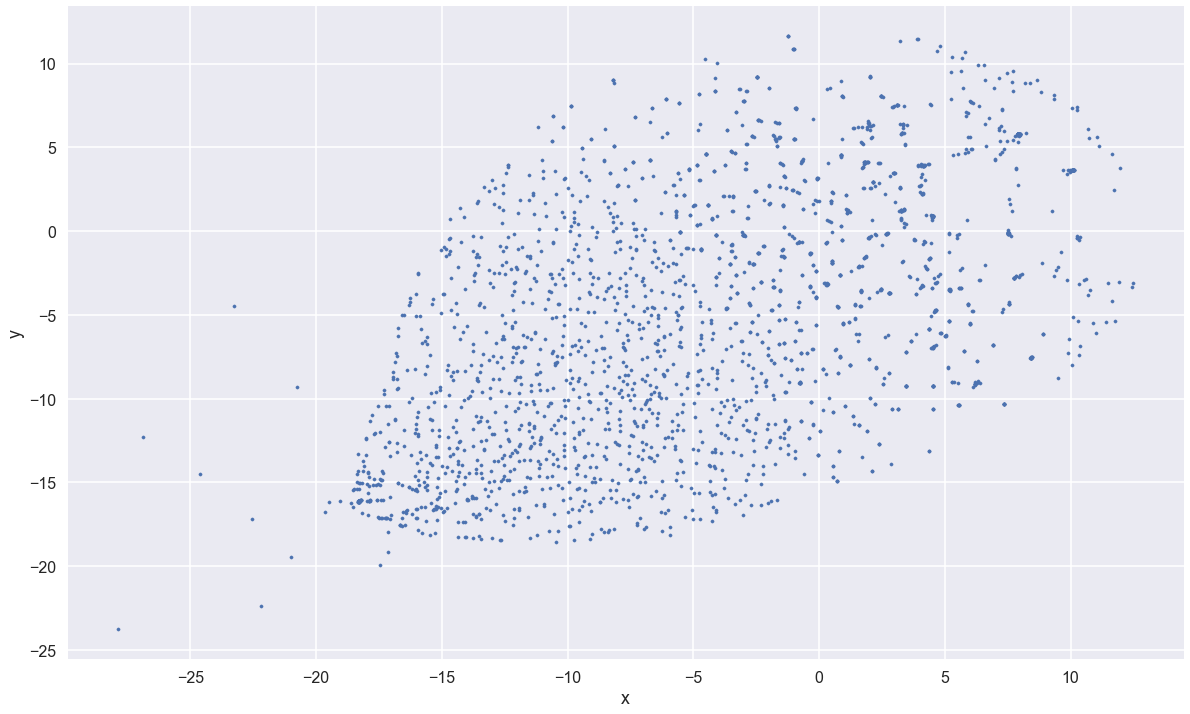

In [594]:
sns.set_context("poster")
points.plot.scatter("x","y", s=10, figsize=(20, 12))

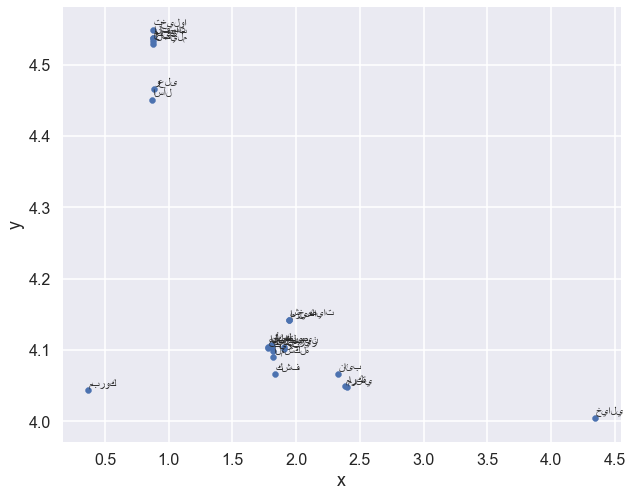

In [595]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
plot_region(x_bounds=(0, 5), y_bounds=(4, 5))

In [596]:
import numpy as np

vec = np.argsort(tf.idf_)[::-1]
features = tf.get_feature_names()
top_features = [features[i] for i in vec]

In [597]:
top_features[:10]

['ثورة',
 'ولكل',
 'تحتاج',
 'دموعهم',
 'بحاول',
 'شنط',
 'الدجال',
 'صبرك',
 'الذنب',
 'تصدق']

In [598]:
pos = nb.feature_count_[0,:]
neg = nb.feature_count_[1,:]
neu = nb.feature_count_[2,:]
nb.feature_count_.shape



(3, 2500)

In [600]:
x_train_tokens  = tf.get_feature_names()
tf.get_feature_names()[:50]

['أبدا',
 'أبل',
 'أبو',
 'أبوظبي',
 'أبي',
 'أثناء',
 'أجل',
 'أجمل',
 'أجهزة',
 'أحب',
 'أحد',
 'أحسن',
 'أحلام',
 'أحلى',
 'أحمد',
 'أحوازنا',
 'أخ',
 'أخبار',
 'أخر',
 'أخرى',
 'أخي',
 'أداء',
 'أدب',
 'أرامكو',
 'أردوغان',
 'أرض',
 'أرم',
 'أريد',
 'أزمة',
 'أزياء',
 'أس',
 'أسأل',
 'أسئلة',
 'أسباب',
 'أسبوع',
 'أسرار',
 'أسرع',
 'أسعار',
 'أشهر',
 'أشياء',
 'أصبح',
 'أصل',
 'أطفال',
 'أعلن',
 'أعلنت',
 'أعلى',
 'أغنية',
 'أفضل',
 'أقرب',
 'أكبر']

# we created a data frame of all the features to see which features affects the label 

In [601]:
tokens = pd.DataFrame({'token': x_train_tokens[:3000], 'positive':pos, 'negative': neg,'neutral': neu}).set_index('token')

tokens.head(5)

,negative,neutral,positive
token,,,
أبدا,2.0,3.0,1.0
أبل,34.0,28.0,14.0
أبو,3.0,4.0,6.0
أبوظبي,3.0,1.0,0.0
أبي,1.0,1.0,0.0


In [602]:
tokens.sort_values('neutral',ascending=False).head(10)


,negative,neutral,positive
token,,,
منشن,739.0,566.0,647.0
لينك,757.0,418.0,436.0
من,334.0,243.0,329.0
في,367.0,227.0,333.0
على,207.0,162.0,191.0
الله,76.0,145.0,60.0
يا,59.0,121.0,138.0
سعيد,75.0,89.0,52.0
كل,46.0,85.0,78.0


# project by:

# Muhammed Mahmoud AbdelHameed
# muha.eltabakh@gmail.com

# Nourhan Abdelaal Ali
# Nourhan.a.ali@gmail.com
